In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

from scipy.linalg import expm

import pennylane as qml
from pennylane import numpy as np

In [2]:
name ='LiH';charge = 0;multiplicity=1;basis= 'sto-3g';geometry = 'lih.xyz';
h, nr_qubits = qml.qchem.generate_hamiltonian(
    name,
    geometry,
    charge,
    multiplicity,
    basis,
    mapping='jordan_wigner',
    n_active_orbitals=2,
    n_active_electrons=2,
)
print(nr_qubits)

4


In [3]:
class Phase_Shift(qml.operation.Operation):
    num_params = 1
    num_wires = 1
    par_domain = "R"
    grad_method = "A"
    generator = [np.array([[0, 0], [0, 1]]), -0.5]

    @staticmethod
    def _matrix(*params):
        return np.array([[1, 0], [0, np.exp(-1j * params[0]/2)]])

In [4]:
class eSWAP(qml.operation.Operation):
    num_params = 1
    num_wires = 2
    par_domain = "R"
    grad_method = "A"

    @staticmethod
    @qml.template 
    def decomposition(theta, wires):
        qml.CNOT(wires=[wires[0], wires[1]])
        qml.CRX(theta, wires=[wires[1], wires[0]])
        qml.PauliX(wires=wires[0])
        Phase_Shift(theta, wires=wires[0])
        qml.PauliX(wires=wires[0])
        qml.CNOT(wires=[wires[0], wires[1]])

In [5]:
dev = qml.device("default.qubit", wires=4)

dev.operations.update({"Phase_Shift"})

In [6]:
def circuit(params, wires=[0,1,2,3]):
    qml.PauliX(wires=wires[0])
    qml.PauliX(wires=wires[1])
    qml.PauliX(wires=wires[2])
    qml.PauliX(wires=wires[3])
    
    qml.Hadamard(wires=wires[0])
    qml.Hadamard(wires=wires[2])

    qml.CNOT(wires=[wires[0], wires[1]])
    qml.CNOT(wires=[wires[2], wires[3]])

    eSWAP(params[0], wires=[wires[1], wires[2]])
    eSWAP(params[1], wires=[wires[0], wires[3]])
    eSWAP(params[2], wires=[wires[0], wires[1]])
    eSWAP(params[3], wires=[wires[2], wires[3]])
    
    eSWAP(params[4], wires=[wires[1], wires[2]])
    eSWAP(params[5], wires=[wires[0], wires[3]])
    eSWAP(params[6], wires=[wires[0], wires[1]])
    eSWAP(params[7], wires=[wires[2], wires[3]])

    qml.SWAP(wires=[wires[1], wires[2]])
    qml.SWAP(wires=[wires[0], wires[1]])
    qml.SWAP(wires=[wires[2], wires[3]])
    qml.SWAP(wires=[wires[1], wires[2]])
    qml.SWAP(wires=[wires[2], wires[3]])

In [7]:
initial_params = np.random.uniform(low=0, high=4*np.pi, size=8)

In [8]:
qnodes = qml.map(circuit, h.ops, dev, measure='expval')
cost = qml.dot([h.coeffs], qnodes)

In [9]:
cost(initial_params)

array([-7.66785211])

In [10]:
max_iter = 200
step_size = 0.05
conv_tol = 1e-6

energycost = []
params = initial_params
prev_energy = cost(initial_params)

for n in range(max_iter):
    gradient = qml.grad(cost, argnum=[0])
    grad_at_point = [float(i) for i in gradient(params)[0]]
    
    params = params - step_size * np.dot(
                np.linalg.pinv(qnodes[0].metric_tensor([params])), grad_at_point)
    
    energy = cost(params)
    energycost.append(energy)
    conv = abs(energy - prev_energy)
    
    prev_energy = energy
    
    
    if conv <= conv_tol:
        print('found ground-state at step {:}'.format(n))
        print("Ground-state energy = ", energy)
        break
    if n % 10 == 0:
        print('step = {:} \n energy = {:} \n convergence = {:} ha'.format(n, energy, conv))

step = 0 
 energy = [-7.67340722] 
 convergence = [0.00555511] ha
step = 10 
 energy = [-7.69053079] 
 convergence = [0.00037508] ha
step = 20 
 energy = [-7.69221746] 
 convergence = [0.0001074] ha
step = 30 
 energy = [-7.69220118] 
 convergence = [0.00068843] ha
step = 40 
 energy = [-7.69370131] 
 convergence = [0.00395892] ha
step = 50 
 energy = [-7.69378379] 
 convergence = [0.00211101] ha
step = 60 
 energy = [-7.69530576] 
 convergence = [0.00449162] ha
step = 70 
 energy = [-7.69652859] 
 convergence = [0.00222687] ha
step = 80 
 energy = [-7.69888844] 
 convergence = [0.00058248] ha
step = 90 
 energy = [-7.7031924] 
 convergence = [0.00038921] ha
step = 100 
 energy = [-7.70884105] 
 convergence = [0.00062374] ha
step = 110 
 energy = [-7.71601165] 
 convergence = [0.00078361] ha
step = 120 
 energy = [-7.72437899] 
 convergence = [0.00086643] ha
step = 130 
 energy = [-7.73307327] 
 convergence = [0.00085957] ha
step = 140 
 energy = [-7.74130227] 
 convergence = [0.000784

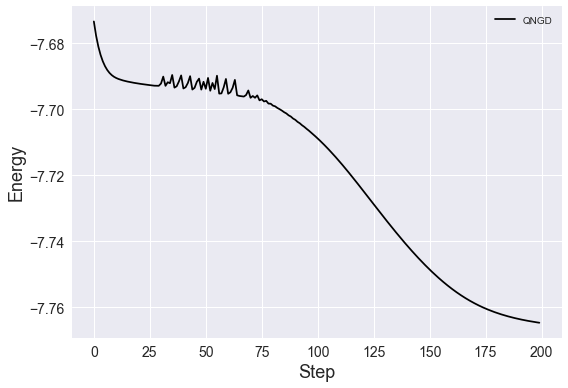

In [11]:
plt.style.use("seaborn")
plt.plot(energycost, "k-", label="QNGD")

plt.ylabel("Energy", fontsize=18)
plt.xlabel("Step", fontsize=18)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

plt.legend()

plt.tight_layout()

In [12]:
# qnodes[0].draw()

In [13]:
from pyquil.wavefunction import Wavefunction

In [14]:
wfn = Wavefunction(dev.state)
print(wfn)

(-0.0084302238-0.0024667436j)|0011> + (-0.0180709144-0.061744027j)|0101> + (-0.0570600237+0.0004521301j)|0110> + (-0.0262382996+0.0430369052j)|1001> + (-0.0521591474-0.0743797887j)|1010> + (-0.3354431088+0.9323155477j)|1100>
